<a href="https://colab.research.google.com/github/VarunHarish98/ComputerVision/blob/main/Image%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> # Name - **Varun Hosadurga Harish** <br>
SBU ID - 115362868 <br>
ESE-568 Computer and Robot Vision




# **1. Image classification**

Image Classification

1. Image classification is a process in which images are classified into various classes.
2. Dataset is loaded off disk and a model is built to classify the images of flowers using tf.keras.Sequential is carried out.
3. The The model is trained and depicts that there exists, high amount of noise in the trained model.
4. It is due to overfitting, where the noise and other unwanted details are getting trained.
5. In order to rectify it, 2 methods are used.

  * <b>Data Augmentation</b> - Carries out random rotation and random zoom across the 3 RGB channels.
  * <b>Dropout</b> - In this method, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process.

6. Adam's Optimiser method is implied for Optimisation and () as a loss function for easier computation.
7. After these steps, the models seems to do better with reduction in loss.
8. Moreover, at last model is converted to TenserFlow Lite for on-device machne learning on mobile, embedded and IoT devices.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

228813984/228813984 [==============================] - 7s 0us/step


In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


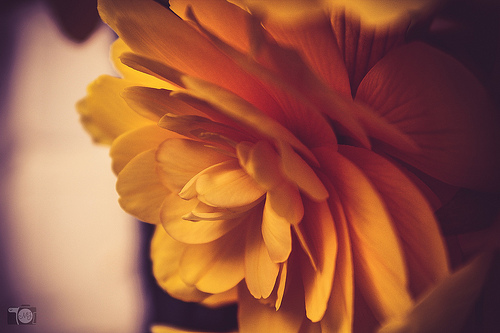

In [4]:
# Display the list of images from roses, dandelion, tulips, sunflowers and daisy
# Here, roses are selected, can be used for other flowers too!

roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))
# dandelion = list(data_dir.glob('dandelion/*'))
# PIL.Image.open(str(dandelion[0]))
# tulips = list(data_dir.glob('tulips/*'))
# PIL.Image.open(str(tulips[0]))
# sunflowers = list(data_dir.glob('sunflowers/*'))
# PIL.Image.open(str(sunflowers[0]))
# daisy = list(data_dir.glob('daisy/*'))
# PIL.Image.open(str(daisy[0]))

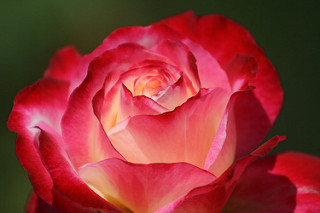

In [5]:
PIL.Image.open(str(roses[5]))

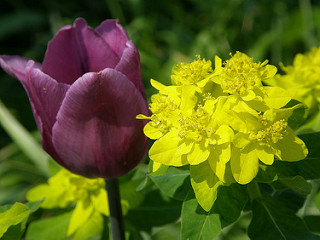

In [6]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

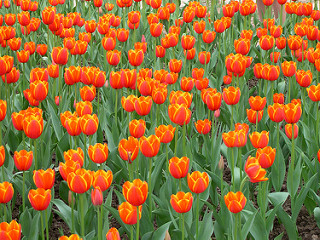

In [7]:
PIL.Image.open(str(tulips[1]))

* We have imported as set of 3670 images from the https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz ,we need to use them from the disk. <br>
* We use `tf.keras.utils.image_dataset_from_directory` utility function
`tf.keras.utils.image_dataset_from_directory` - Simplifies process of creating datasets from directory which contain images.

### Create a dataset

In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
# It is better to use some part of model for training and validation instead of
# only training, choose 80% training and 20% validation for a good model.
# seed - it is used to generate a same set of random number every time it is run, when
# splitting data into training and validation sets.
# validation_split - used to evaluate model during training, but not to train model
# 80% for training i.e 0.8*3670 - 2936 for training
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
# 20% for validation i.e 0.2*3670 - 734 for validation.
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


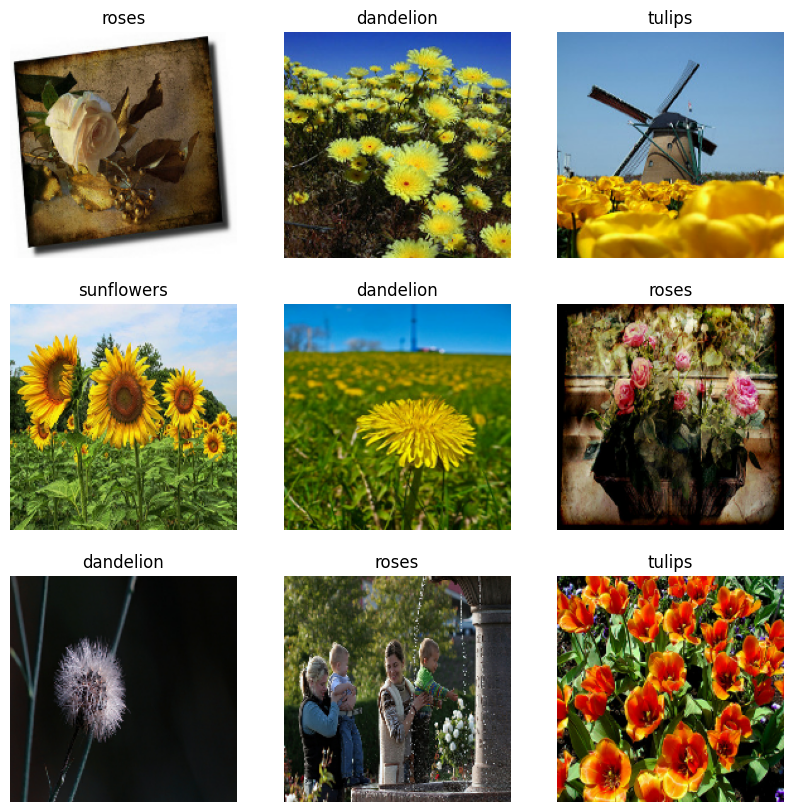

In [12]:
# Plot the images from the training datasets into a subplot

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [13]:
# Optional - If needed to print the shape of the image and labels where,
# - there exists 32 batches of images and size of 180*180 with 3 channels (RGB)
# - Hence it is (32*180*180*3)
# - (32,) - denotes corresponding labels to 32 images as it has 32 as batch size.
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [14]:
# Defines number of parallel calls, adjust based on requirement
# Epoch - defines number of times a model has gone through the dataset
# Eg. - one epoch means that the model has gone through the entire training dataset once

AUTOTUNE = tf.data.AUTOTUNE

# shuffle - done, so that models gets a diverse set of example during each ITERATION/EPOCH
# prefetch - prefetch elements while current iteration is running, better for training, during each epoch
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Repeat the same for validation dataset - val_ds
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
# Rescaling [0,255] of standard RGB into [0,1], easy for computation in Convolution Neural Networks
normalization_layer = layers.Rescaling(1./255)

In [16]:
# Map each value of normalized layer into y
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# Gets next batch of data from the iterator, where, it is then resolved into
# - 2 variables which contains normalized input and image labels
image_batch, labels_batch = next(iter(normalized_ds))
# Get the first image from normalised image_batch
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [17]:
num_classes = len(class_names)
# Rescale - rescale the image into [0,1] i.e normalize it, along all the 3 channels (RGB)
# 2D Convolution - Carry out convolution with 16, 32, 64 filters with kernel size of 3X3 with activation function
# - of ReLU - Rectified Linear Unit is done in incremental steps after max pooling.
# Max Pooling - In order to reduce the dimension for easy computation, max pooling is used.
# Flatten - Done to flatten the 2D into single dimension array.
# Dense - Fully connected layer with 128 units and activation function as ReLU.

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [18]:
# Adam Optimizer - Adaptive Moment Estimation - minimize loss function during training of neural networks
# Uses Stochastic Gradient Descent Algorithm with momentum approach
# Used as requires less memory requirements.

# Loss function - SparseCategoricalCrossentropy
# Used to measure, how well the model is performing, it applies softmax function internally.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [20]:
# Training phase and fit for 10 epochs - train the model for 10 complete iterations

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 15s 46ms/step - loss: 1.3942 - accuracy: 0.4292 - val_loss: 1.1591 - val_accuracy: 0.5286
Epoch 2/10
92/92 [==============================] - 2s 20ms/step - loss: 0.9865 - accuracy: 0.6127 - val_loss: 0.9426 - val_accuracy: 0.6090
Epoch 3/10
92/92 [==============================] - 2s 20ms/step - loss: 0.7593 - accuracy: 0.7214 - val_loss: 0.9747 - val_accuracy: 0.6294
Epoch 4/10
92/92 [==============================] - 2s 21ms/step - loss: 0.5518 - accuracy: 0.8059 - val_loss: 1.1273 - val_accuracy: 0.6063
Epoch 5/10
92/92 [==============================] - 2s 20ms/step - loss: 0.3758 - accuracy: 0.8668 - val_loss: 1.0655 - val_accuracy: 0.6322
Epoch 6/10
92/92 [==============================] - 2s 21ms/step - loss: 0.1974 - accuracy: 0.9366 - val_loss: 1.4583 - val_accuracy: 0.6226
Epoch 7/10
92/92 [==============================] - 2s 23ms/step - loss: 0.1216 - accuracy: 0.9632 - val_loss: 1.6454 - val_accuracy: 0.6226
Epoch 8/10
9

## Visualize training results

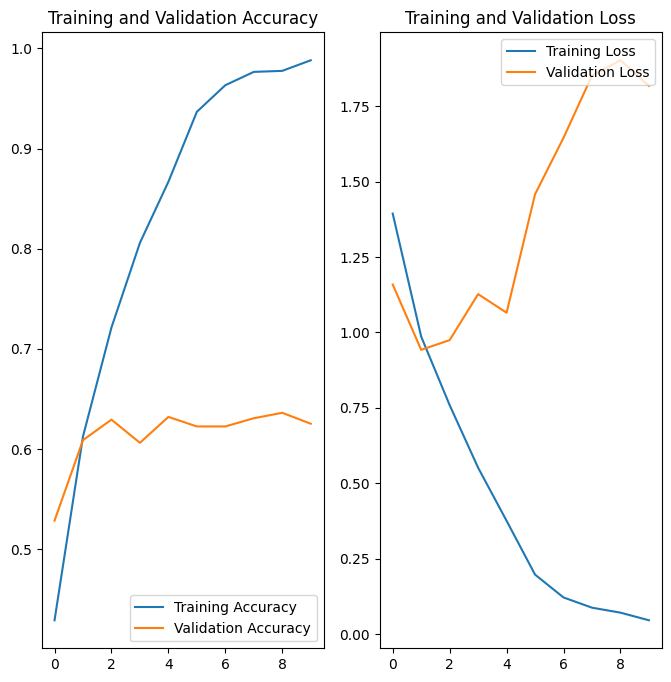

In [21]:
# Plot the graph of Training vs Validation Accuracy for 0-10 epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot the graph of Training vs Validation Loss for 0-10 epochs

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<b>Inference from the graph</b>
<ol>
  <li> Validation accuracy for the graph seems to be at 60%, which are off by huge margins for a model and can be improved further.
  <li> It can be due to Overfitting, where the model is learning from noise and other unwanted detials, which is degrading the accuracy.
  <li> It can be solved by 2 methods
  <ul>
  <li>
  <dl>
      <dt>Data augmentation</dt>
      <dd>- Generates additional training data from existing examples by augmenting them using random transformations that yield believable-looking images.</dd>
      <li><dt>Dropout</dt>
      <dd>- It dropouts a number of output units from the layer during the training process.</dd>
  </dl>
  </ul>
</ol>

## Overfitting Solutions

## Data augmentation

In [22]:
# Apply Data Augmentation to the model
#   - By carrying out random rotation and random zoom across the 3 RGB channels
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

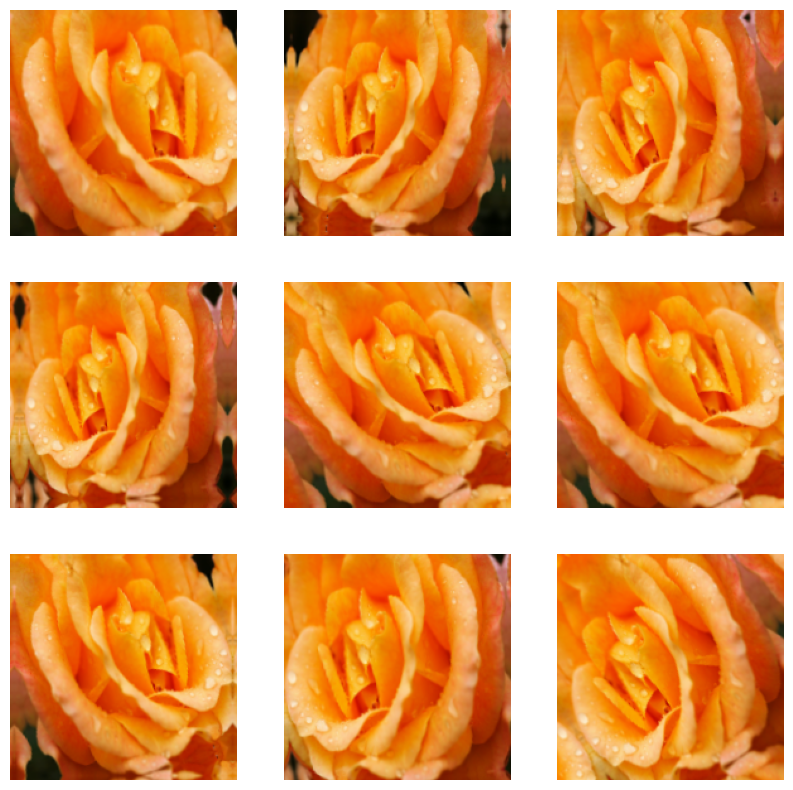

In [23]:
# Plot the augmented data and display for the trained dataset values

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout Method


In [24]:
# Create a new neural network before using the process of dropout
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [25]:
# Use the same adam optimiser and SparseCategoricalCrossentropy for loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
# Display all the values of model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [27]:
# Training phase and fit for 15 epochs - train the model for 10 complete iterations

epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 6s 34ms/step - loss: 1.2160 - accuracy: 0.4949 - val_loss: 1.0939 - val_accuracy: 0.5763
Epoch 2/15
92/92 [==============================] - 3s 29ms/step - loss: 1.0012 - accuracy: 0.6035 - val_loss: 0.9248 - val_accuracy: 0.6308
Epoch 3/15
92/92 [==============================] - 3s 29ms/step - loss: 0.8975 - accuracy: 0.6533 - val_loss: 0.8998 - val_accuracy: 0.6635
Epoch 4/15
92/92 [==============================] - 3s 29ms/step - loss: 0.8316 - accuracy: 0.6771 - val_loss: 0.9351 - val_accuracy: 0.6540
Epoch 5/15
92/92 [==============================] - 3s 29ms/step - loss: 0.7798 - accuracy: 0.7030 - val_loss: 0.8275 - val_accuracy: 0.6717
Epoch 6/15
92/92 [==============================] - 3s 31ms/step - loss: 0.7523 - accuracy: 0.7153 - val_loss: 0.7563 - val_accuracy: 0.7057
Epoch 7/15
92/92 [==============================] - 3s 29ms/step - loss: 0.7026 - accuracy: 0.7309 - val_loss: 0.8219 - val_accuracy: 0.6703
Epoch 8/15
92

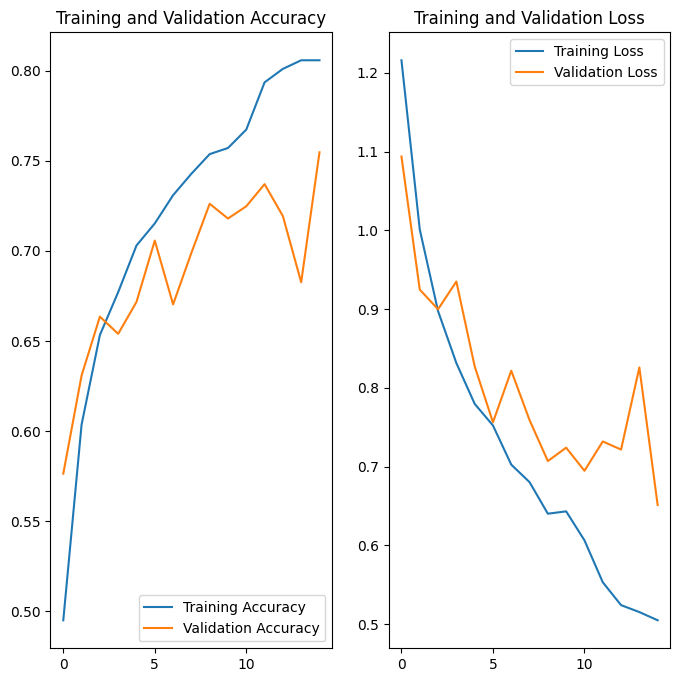

In [28]:
# Plot the graph of Training vs Validation Accuracy for 0-15 epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot the graph of Training vs Validation Loss for 0-15 epochs

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Inference from Graph**
<ol>
<li>Training accuracy vs validation accuracy has improved after applying Data augmentation and Dropout, denotes model is trained and validated in a better way with better accurate results than earlier., i.e., there is less overfitting than before, and training and validation accuracy are closer aligned
</ol>

## Predict on new data

Test - Using the model to classify an image that wasn't included in the training or validation sets.

In [29]:
# Using our model to to classify an image that wasn't a part of training or validation sets and
# - check whether it produces accurate results.

sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
print(predictions)

1/1 [==============================] - 0s 167ms/step
This image most likely belongs to sunflowers with a 99.53 percent confidence.
[[-5.497483   -0.50726724 -0.4615089   7.81569     2.3439226 ]]


### Convert the Keras Sequential model to a TensorFlow Lite model

In [30]:
# Convert the model into TensorFlow Lite model from Keraas model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

## TensorFlow Lite model



In [31]:
# Run the TensorFlow Lite model from the default path and interpreter class.

TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

Print the signatures from the converted model to obtain the names of the inputs (and outputs):


In [32]:
# Get all the signatures from model to get the names of inputs
# inputs - sequential_2_input
# outputs - outputs

interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

In [33]:
# Need to test the loaded TensorFlow by performing inference on sample image, by passing signature name

classify_lite = interpreter.get_signature_runner('serving_default')
print(classify_lite)

In [35]:
#Use the TensorFlow Lite model to classify the image that weren't included in training/validation sets.
# Compute the softmax function (activation function) and gives the prediction for class with highest computed probability.
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [36]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to sunflowers with a 99.53 percent confidence.


The prediction generated by the lite model should be almost identical to the predictions generated by the original model:

In [37]:
print(np.max(np.abs(predictions - predictions_lite)))

1.5497208e-06
